In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv

In [2]:
data_path = '/home/gonzalez/Desktop/age_gender/age_gender.csv'
url = 'https://www.kaggle.com/code/shahraizanwar/age-gender-ethnicity-prediction/data?select=age_gender.csv'

In [3]:
data = pd.read_csv(data_path)

In [4]:
data.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

# Loading data from google cloud to google colab

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/age_gender.csv')

 # Transforming the pixels data type into a list of float

In [ ]:
# images =[]
# for fotos in range(len(data['pixels'])):
#     X = data['pixels'][fotos].split(" ")
#     X = list(map(int, X))
#     images.append(X)

In [ ]:
# x = np.reshape(images[5000], (48,48))

In [5]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [ ]:
blob = data['pixels'][0].reshape(48,48)

In [ ]:
plt.imshow(blob, cmap='gray');

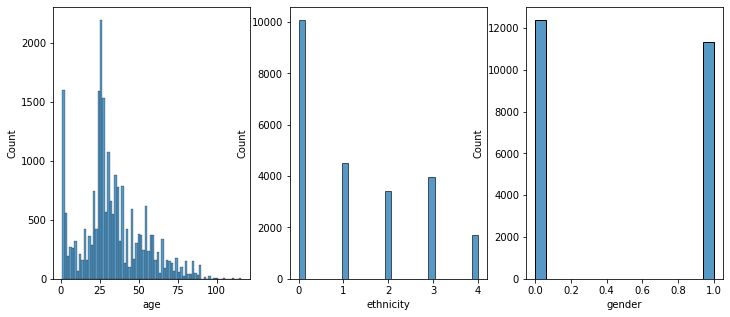

In [6]:
#sns.displot(data['ethnicity']),
#sns.displot(data['gender']), 
#sns.displot(data['age']);
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.histplot(ax=axes[0], x=data['age']);
sns.histplot(ax=axes[1], x=data['ethnicity']);
sns.histplot(ax=axes[2], x=data['gender']);

# Working with the age

In [ ]:
# list the number of counts per age
ages = data['age'].unique()
counts = []
for age in ages:
    counts.append(np.count_nonzero(data['age']==age))

In [ ]:
# table with the first 15 most dense samples regarding age
type(ages), type(counts)
s =pd.DataFrame([ages.T, np.array(counts).T],['ages', 'counts'])
s=s.transpose()
more_dense = s.sort_values(by=['counts'], ascending=False)
more_dense.head(15)

# Function for transforming data numbers into data range classification

In [ ]:
# categorize age per range:
def age_categorize(input_list, age_step=10):
    '''
    Enter the list of age into input_list and the age steps
    with : age_step = 5;  age = 4   =>  1-5
                          age = 12  =>  10-15                        
    '''
    
    cat_age = []
    for age in input_list:
        
        a = float(age)/float(age_step)
        
        if a > 1:
            entero = int(a)
            coma = a-entero
            
            if coma > 0:
                entero = entero+1
            
            max = entero * age_step
            min = max-(age_step-1)     
            cat_age.append(f'{min} to {max}')
        else:
            min = 1
            max = age_step
            cat_age.append(f'{min} to {max}')
            
    return cat_age

In [ ]:
step_size = 3
input_list = data['age']
cat = age_categorize(input_list)

In [ ]:
pd.DataFrame(cat, data['age'].values).sample(100)

In [ ]:
input_list = data['age'].unique

In [ ]:
data['ethnicity'].unique()

# Here we go with the model

In [8]:
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

In [9]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y = data['age']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen=ImageDataGenerator(rescale=1/255)
# train_generator_age=train_datagen.flow(
#     X_train ,y_train ,batch_size=32)

# test_datagen=ImageDataGenerator(rescale=1/255)
# test_generator_age=test_datagen.flow(
#     X_test ,y_test ,batch_size=32)

In [10]:
def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

In [11]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

2022-05-31 16:25:30.299398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/gonzalez/TOOLS/elmer/install//lib
2022-05-31 16:25:30.299423: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-31 16:25:30.299443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gonzalez-Latitude): /proc/driver/nvidia/version does not exist
2022-05-31 16:25:30.299651: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# earlystop=EarlyStopping(patience=6)
# learning_rate_reduction=ReduceLROnPlateau(
#     monitor='val_acc',
#     patience= 3,
#     verbose=1,
# )
# callbacks = [earlystop, learning_rate_reduction]

TypeError: __init__() got an unexpected keyword argument 'learning_rate'

In [ ]:
X_train.shape

In [ ]:
# history_age = model.fit(
#     train_generator_age, 
#     epochs= 60,
#     validation_data= test_generator_age,
#     callbacks= callbacks)

In [ ]:
history = model.fit(X_train, y_train, epochs=80, callbacks=[es])

In [25]:
history = model.fit(X, y, validation_split=0.3, epochs=100, callbacks=[es], batch_size=32)

Epoch 1/100
212/519 [===========>..................] - ETA: 14s - loss: 60.7770 - mae: 5.7333

KeyboardInterrupt: 

In [17]:
history.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x7fb0ebdc8700>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [210.4229736328125,
   94.75850677490234,
   83.65867614746094,
   78.30268096923828,
   76.32720947265625,
   70.48189544677734,
   68.04656982421875,
   67.17091369628906,
   64.46505737304688,
   61.433021545410156,
   60.2575569152832,
   60.070762634277344,
   56.00049591064453,
   56.22001647949219,
   54.14469909667969,
   53.2535285949707],
  'mae': [10.901667594909668,
   7.2612810134887695,
   6.7426652908325195,
   6.496629238128662,
   6.382981777191162,
   6.125398635864258,
   6.053933620452881,
   5.980057716369629,
   5.906715393066406,
   5.780670642852783,
   5.743369102478027,
   5.728079319000244,
   5.598702430725098,
   5.609117031097412,
   5.486659526824951,
   5.472993850708008],
  'val_loss': [1389.8895263671875,
   1158.2996826171875,
   1125.4364013671875,
   1190.7802734375,
   873.7637329

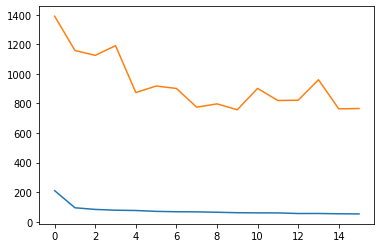

In [19]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

In [ ]:
# models.save_model(model, 'Model48')
model = models.load_model('Model48')

In [ ]:
model.evaluate(X_test,y_test)

NameError: name 'y_test' is not defined

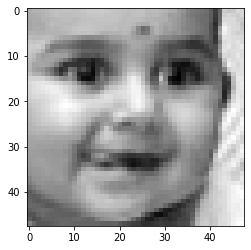

In [27]:
n=242
plt.imshow(X[n], cmap='gray');
y_test.iloc[n]

In [ ]:
#out= model.predict(X_test)
try_inp = np.expand_dims(X_test[n], axis=0)
model.predict(try_inp)[0,0]

In [29]:
np.shape(X[0])

(48, 48, 1)

# best results using colab

In [30]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv

from google.colab import drive 
drive.mount('/content/gdrive')
data=pd.read_csv('gdrive/My Drive/age_gender.csv')

data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y = data['age']


def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

model = initialize_model()
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

history = model.fit(X_train, y_train, epochs=100, callbacks=[es])

plt.plot(history.history['loss']);
plt.plot(history.history['mae']);

n=5
out = np.reshape(X_test[n], (48, 48))
plt.imshow(out, cmap='gray');
y_test.iloc[n]

try_inp = np.expand_dims(X_test[n], axis=0)
model.predict(try_inp)[0,0]

ModuleNotFoundError: No module named 'google.colab'